In [1]:
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import sys

In [2]:
import scipy as sp
import plotly as py

In [3]:
import chart_studio.plotly as py

In [4]:
plup = pd.read_csv("D:/qgis/usda_plant_symbols.csv")

In [5]:
plup["SciName"] =plup.apply(lambda r: " ".join(r['Scientific Name with Author'].split()[:2]), axis=1)  
plu = plup.drop_duplicates(subset=["SciName"]).set_index('SciName')

In [6]:
dmp_flora = pd.read_excel("C:/Users/ajc/Documents/Downloads/DFPPlants.xlsx")

In [7]:
lookup_list = dmp_flora.join(plu, on="SciName").set_index("SciName")

In [8]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

In [9]:
sn = "Acer negundo"
sn = "Asclepias incarnata"

In [10]:
lookup_list.loc[[sn]]["Symbol"].values[0]

'ASIN'

In [11]:
def get_lb_page_for_sci_name(sn):
    symbol = lookup_list.loc[[sn]]["Symbol"].values[0]
    url_template = f"https://www.wildflower.org/plants/result.php?id_plant={symbol}"
    #print(url_template)
    res = requests.get(url_template, headers=headers)
    if res.status_code != 200:
        sys.exit("page request failed")
    soup = BeautifulSoup(res.text, 'lxml')
    return (soup, sn, symbol)
 

In [12]:
def get_lb_data_from_soup(soup, sn, symbol):
    #print('Getting Lady Bird data from soup')
    rec = {"SciName": sn, 
           "Symbol": symbol, 
           "Bloom Time:": " ",
           "Jan": 0,
           "Feb": 0,
           "Mar": 0,
           "Apr": 0,
           "May": 0,
           "Jun": 0,
           "Jul": 0,
           "Aug": 0,
           "Sep": 0,
           "Oct": 0,
           "Nov": 0,
           "Dec": 0,
           "Special Value to Native Bees": 0 ,
           "Special Value to Bumble Bees": 0, 
           "Nectar Source:": 0, 
           "Larval Host:": "No",
           "Larval Host(Monarch)": 0,
           "Larval Host(Other)": 0}
    h4s = soup.find_all("h4")
    #print("h4's found: ",h4s)
    for n in h4s:
        #print('\n\n', '####', n, n.string)
        if n.string == "Bloom Information":
            #print("Found Bloom Information")
            sibs = n.find_next_siblings()
            for s in sibs:
                #print(s)
                if s.string == "Bloom Time:":
                    #print(n.parent)
                    #print(s)
                    #print(s.next_sibling)
                    mos = s.next_sibling.split(",")
                    for m in mos:
                        rec[m.strip()] = 1                    
                    rec[s.string] = s.next_sibling
        if n.string == "Benefit":
            sibs = n.find_next_siblings()
            for s in sibs:
                #print(s)
                if s.string == "Nectar Source:":
                    print("found benefit for ", sn, symbol)
                    #print(n.parent)
                    #print(s)
                    #print(s.next_sibling)
                    rec[s.string] = 1
                if s.string == "Larval Host:":
                    print("found benefit for ", sn, symbol)
                    #print(n.parent)
                    #print(s)
                    #print(s.next_sibling)
                    rec[s.string] = s.next_sibling
                    if "onarch" in s.next_sibling:
                        rec["Larval Host(Monarch)"] = 1
                    else: 
                        rec["Larval Host(Other)"] = 1
        if n.string == "Value to Beneficial Insects":
            #print(n.parent.prettify())
            for s in n.find_next_siblings():
                #print(s)
                if s.string: 
                    if (s.string.strip().startswith("Special") and (s.string.find("Honey") == -1)):
                        #print('adding string', s)
                        rec[s.string.replace("\xa0", " ")] = 1
                #print(s.next_sibling)
                if (str(s.next_sibling).strip().startswith("Special") and (str(s.next_sibling).find("Honey") == -1)):
                    #print("adding next sibling", s.next_sibling)
                    rec[str(s.next_sibling.strip().replace("\xa0", " "))] = 1                
    return rec

In [13]:
rec_list = []
for plant in dmp_flora.SciName.values:
    #print(plant)
    page, sn, symbol = get_lb_page_for_sci_name(plant)
    rec_list.append(get_lb_data_from_soup(page, sn, symbol))


found benefit for  Acer rubrum ACRU
found benefit for  Allium cernuum ALCE2
found benefit for  Amaranthus tuberculatus AMTU
found benefit for  Andropogon gerardii ANGE
found benefit for  Angelica atropurpurea ANAT
found benefit for  Antennaria neglecta ANHON
found benefit for  Apios americana APAM
found benefit for  Apocynum sibiricum APCA
found benefit for  Aristida oligantha AROL
found benefit for  Asclepias incarnata ASIN
found benefit for  Asclepias incarnata ASIN
found benefit for  Asclepias sullivantii ASSU3
found benefit for  Asclepias syriaca ASSY
found benefit for  Asclepias tuberosa ASTU
found benefit for  Asclepias tuberosa ASTU
found benefit for  Asclepias verticillata ASVE
found benefit for  Betula papyrifera BEPA
found benefit for  Boehmeria cylindrica BOCY
found benefit for  Boltonia asteroides BOAS
found benefit for  Bouteloua curtipendula BOCU
found benefit for  Brachyelytrum erectum BRER2
found benefit for  Buchloe dactyloides BODA2
found benefit for  Campsis radicans

In [15]:
df = pd.DataFrame(rec_list)
df

,SciName,Symbol,Bloom Time:,Jan,Feb,Mar,Apr,May,Jun,Jul,...,Sep,Oct,Nov,Dec,Special Value to Native Bees,Special Value to Bumble Bees,Nectar Source:,Larval Host:,Larval Host(Monarch),Larval Host(Other)
0,Abutilon theophrasti,ABTH,,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,No,0,0
1,Acer negundo,ACNE2,"Mar , Apr",0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,No,0,0
2,Acer nigrum,ACFL,Apr,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,No,0,0
3,Acer rubrum,ACRU,"Mar , Apr",0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,Cecropia Moth (,0,1
4,Acer saccharinum,ACFL,Apr,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,No,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,Wolffia columbiana,WOCO,"Jun , Jul , Aug , Sep",0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,No,0,0
635,Yucca flaccida,NaN,,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,No,0,0
636,Zea mays,ZEMA,,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,No,0,0
637,Zizania aquatica,ZIAQ,"Jun , Jul , Aug",0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,No,0,0


In [16]:
df.to_excel("G:/My Drive/PlantInfo/LadyBirdData.xlsx")

In [17]:
obs = pd.read_excel("G:/My Drive/PlantInfo/DMP Flora by EcoUnit_pivot_v2 (version 1).xlsb.xlsx", sheet_name="Observations")

In [18]:
obs.head(10)

,PresName,EcosUnit,EcosName,GenType,CommType,CommName,SciName,Year,UnitArea
0,Dunham,CUMDU,Cumulative,Prairie,Prairie Re-creation,Leafy Lupine,Lupinus polyphyllus,2020,NaN
1,Belleau Woods,EBE02,BELLEAU PRAIRIE,Eurasian Meadow,Shrub Meadow,Multiflora Rose,Rosa multiflora,2007,9.792282e+04
2,Belleau Woods,EBE02,BELLEAU PRAIRIE,Eurasian Meadow,Shrub Meadow,Multiflora Rose,Rosa multiflora,2010,9.792282e+04
3,Belleau Woods,EBE05,NORTH MEADOW,Eurasian Meadow,Shrub Meadow,Chinese Buckthorn,Rhamnus utilis,2004,1.849384e+05
4,Belleau Woods,EBE05,NORTH MEADOW,Eurasian Meadow,Shrub Meadow,Multiflora Rose,Rosa multiflora,2004,1.849384e+05
5,Belleau Woods,EBE06,NORTH FLOODPLAIN,Forest,Immature Bottomland Forest,Boxelder,Acer negundo,2004,1.365545e+06
6,Belleau Woods,EBE06,NORTH FLOODPLAIN,Forest,Immature Bottomland Forest,Boxelder,Acer negundo,2010,1.365545e+06
7,Belleau Woods,EBE06,NORTH FLOODPLAIN,Forest,Immature Bottomland Forest,Boxelder,Acer negundo,2015,1.365545e+06
8,Belleau Woods,EBE06,NORTH FLOODPLAIN,Forest,Immature Bottomland Forest,Garlic Mustard,Alliaria petiolata,2004,1.365545e+06
9,Belleau Woods,EBE06,NORTH FLOODPLAIN,Forest,Immature Bottomland Forest,Garlic Mustard,Alliaria petiolata,2015,1.365545e+06


In [27]:
oo = obs.join(df.reset_index().set_index("SciName"), on="SciName")
#oo["Interesting?"] = oo.apply(lambda r: (r["Special Value to Native Bees"] == "Yes") | (r["Special Value to Bumble Bees"] == "Yes") | (r["Nectar Source:"] == "yes") | (r["Larval Host:"] != "No"), axis = 1) 
#oo

In [29]:
oo["habitat_index"] = (oo["Special Value to Native Bees"] 
     + oo["Special Value to Bumble Bees"] 
     + oo["Nectar Source:"] 
     + oo["Larval Host(Monarch)"] 
     + oo["Larval Host(Other)"])
oo["# months with blooms"] = (oo["Jan"] + oo["Feb"] + oo["Mar"] + oo["Apr"] 
     + oo["May"] + oo["Jun"] + oo["Jul"] + oo["Aug"] + oo["Sep"] 
     + oo["Oct"] + oo["Nov"] + oo["Dec"] )
int_df = oo[oo.habitat_index > 0]
mdf = int_df.drop_duplicates(subset=["EcosUnit", "Symbol"])

In [30]:
mdf

,PresName,EcosUnit,EcosName,GenType,CommType,CommName,SciName,Year,UnitArea,index,...,Nov,Dec,Special Value to Native Bees,Special Value to Bumble Bees,Nectar Source:,Larval Host:,Larval Host(Monarch),Larval Host(Other),habitat_index,# months with blooms
14,Belleau Woods,EBE07,PARKING AREA,Developed,Mowed Areas,Kentucky Bluegrass,Poa pratensis,2008,7570.878150,440,...,0,0,0,0,0,Common Roadside Skipper (Amblyscirtes vialis)...,0,1,1,4
16,Brush Hill,EBH01,KINGERY PRAIRIES,Prairie,Dry-mesic Prairie,Woolly Cat's Foot,Antennaria neglecta,2003,18480.506052,40,...,0,0,0,0,0,Painted lady,0,1,1,3
17,Brush Hill,EBH01,KINGERY PRAIRIES,Prairie,Dry-mesic Prairie,Plains Three-awn,Aristida oligantha,2003,18480.506052,46,...,1,0,0,0,0,The Grass Family is an essential larval food ...,0,1,1,4
19,Brush Hill,EBH01,KINGERY PRAIRIES,Prairie,Dry-mesic Prairie,Whorled Milkweed,Asclepias verticillata,2010,18480.506052,54,...,0,0,1,1,0,Monarch,1,0,3,5
20,Brush Hill,EBH01,KINGERY PRAIRIES,Prairie,Dry-mesic Prairie,Short Green Milkweed,Asclepias viridiflora,2003,18480.506052,55,...,0,0,1,1,0,No,0,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6474,York Woods,EYO02,SOUTH MARSH,Marsh,Diverse Marsh,Common Boneset,Eupatorium perfoliatum,2006,132781.025000,239,...,0,0,1,0,1,No,0,0,2,5
6477,York Woods,EYO02,SOUTH MARSH,Marsh,Diverse Marsh,Sawtooth Sunflower,Helianthus grosseserratus,2006,132781.025000,267,...,1,0,1,0,0,Checkerspot.,0,1,2,4
6480,York Woods,EYO02,SOUTH MARSH,Marsh,Diverse Marsh,Wild Mint,Mentha canadensis,2006,132781.025000,362,...,0,0,1,0,0,No,0,0,1,3
6491,York Woods,EYO02,SOUTH MARSH,Marsh,Diverse Marsh,Blue Vervain,Verbena hastata,2006,132781.025000,613,...,0,0,1,0,0,Common Buckeye,0,1,2,4


In [31]:
mdf.to_excel("dfp_interesting_units.xlsx")

<AxesSubplot:ylabel='SciName'>

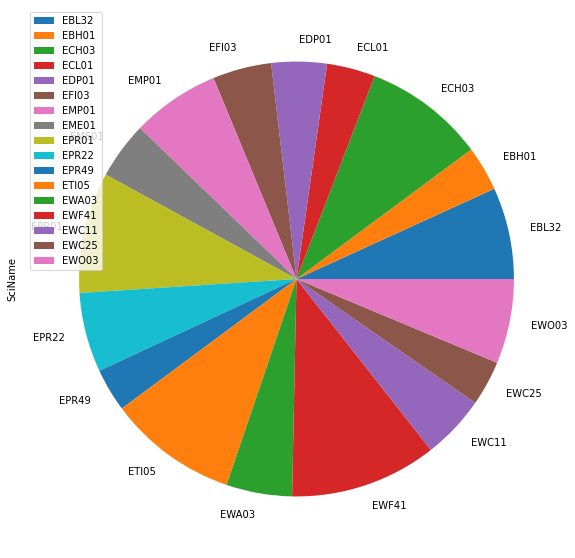

In [85]:
sdf[sdf.SciName > 20].reset_index().set_index("EcosUnit")[["SciName"]].plot.pie(y="SciName", figsize=(10,10))

In [86]:
sdf = oo[oo["Interesting?"]].groupby(['PresName', 'EcosUnit']).agg({"UnitArea": "sum", "SciName": "count"})

<AxesSubplot:ylabel='UnitArea'>

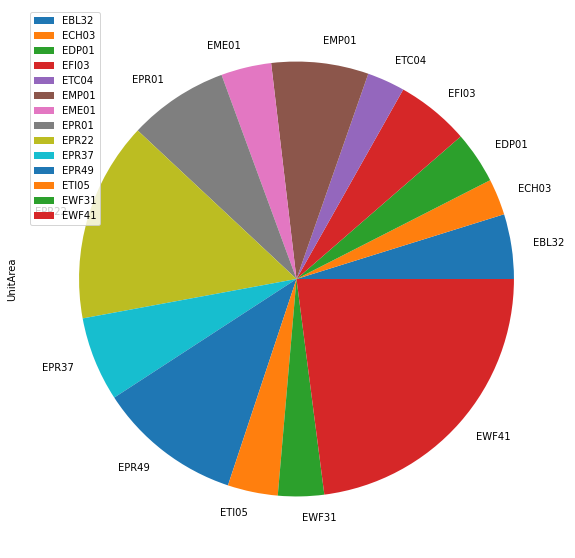

In [88]:
sdf[sdf.UnitArea > 5e7].reset_index().set_index("EcosUnit").plot.pie(y="UnitArea", figsize = (10,10))

In [38]:
oo.columns

Index(['PresName', 'EcosUnit', 'EcosName', 'GenType', 'CommType', 'CommName',
       'SciName', 'Year', 'UnitArea', 'index', 'Symbol', 'Bloom Time:',
       'Special Value to Native Bees', 'Special Value to Bumble Bees',
       'Nectar Source:', 'Larval Host:', 'Special Value to Honey Bees',
       'Interesting?'],
      dtype='object')

In [ ]:
wdf = oo['PresName', 'EcosUnit',

In [41]:
pd.options.display.float_format

In [42]:
pd.options.display.float_format = '{:,.2f}'.format

In [169]:
agg_df = (oo.groupby(["PresName", "EcosUnit", "GenType", "CommType", "UnitArea", "CommName", "SciName", "Bloom Time:",
             "Special Value to Native Bees", "Special Value to Bumble Bees", "Nectar Source:", "Larval Host:", "Year", "Interesting?"])
     .count().drop(columns=["EcosName","index", "Symbol", "Special Value to Honey Bees"]))


In [171]:
agg_df.to_excel("G:/My Drive/PlantInfo/ConservationAreaAnalysis.xlsx")

In [136]:
agg_df[agg_df.reset_index()["Special Value to Native Bees"] != ""]

C:\Users\ajc\AppData\Local\conda\conda\envs\anaconda3a\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [201]:
ldf = oo.reset_index()[oo["Interesting?"]].groupby(["EcosUnit", "CommName", "SciName"] ).first()
#.reset_index()["EcosUnit", "CommName", "SciName"]

In [203]:
ldf = ldf.drop(columns=ldf.columns).reset_index()

In [190]:
ldf.groupby("EcosUnit").agg({"CommName": ", ".join, "SciName": ", ".join})

,CommName,SciName
EcosUnit,,
CUMDU,Leafy Lupine,Lupinus polyphyllus
EBE02,Multiflora Rose,Rosa multiflora
EBE05,"Chinese Buckthorn, Multiflora Rose","Rhamnus utilis, Rosa multiflora"
EBE06,"Boxelder, Garlic Mustard, Giant Ragweed, Water...","Acer negundo, Alliaria petiolata, Ambrosia tri..."
EBE07,"Common Dandelion, Creeping Charlie, Hairy Crab...","Taraxacum officinale, Glechoma hederacea, Digi..."
...,...,...
ewa06,Skunk Cabbage,Symplocarpus foetidus
ewc08,"Common Mountain Mint, Cowbane, Illinois Bundle...","Pycnanthemum virginianum, Oxypolis rigidior, D..."
ewd07,"Common Forget-Me-Not, Fen Panicled Sedge, Fen ...","Myosotis scorpioides, Carex prairea, Carex ste..."


In [211]:
ldf.groupby("EcosUnit").agg({"SciName": "count"}).to_excel("G:/My Drive/PlantInfo/PlantCount.xlsx")

In [212]:
ldf.groupby("EcosUnit").agg({"SciName": "count"}).to_csv("G:/My Drive/PlantInfo/PlantCount.csv")

In [90]:
idf = oo[oo["Interesting?"]]

<AxesSubplot:xlabel='UnitArea', ylabel='SciName'>

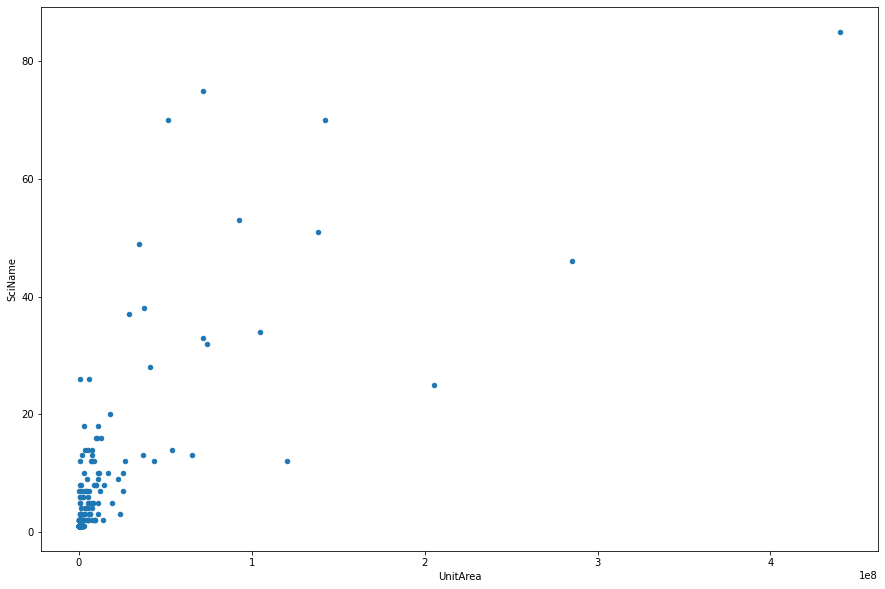

In [95]:
sdf.sort_values("UnitArea").plot.scatter(x="UnitArea", y="SciName", figsize=(15,10))